In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
import copy
import cv2
import math
from matplotlib import animation, rc
from IPython.display import HTML
%matplotlib inline

In [2]:
from mpl_toolkits.mplot3d import Axes3D

In [3]:
exp_dir = "/mnt/recordings/ExperimentData/"
anl_dir = "/mnt/recordings/AnalysisResult/Tomii/2017-07-19/"

df_path = anl_dir + "pv_stim.csv"

pv_thre = 0.7


In [4]:
df = pd.read_csv(df_path)
print "N:",len(df)
#df

N: 37


In [10]:
sessions = range(len(df))

#sessions =  range(5)

#sessions = [3]

#sessions = range(6)


In [13]:
vel_pre = []
vel_pst = []

for i in sessions:
    
    s = df.loc[i,:]
    #print s
    
    sample = s["sample"]
    session = s["session"]
    f_stim = s["frame_stim"]
    stim_x = s["stim_x"]
    stim_y = s["stim_y"]
    
    target = "{0}/{1}/C001H001S{2:0>4}".format(exp_dir, sample, session)    
    save_dir = target.replace(exp_dir, anl_dir)    
    
    elec_phase = np.loadtxt(os.path.join(save_dir, "elec_phase.log"), delimiter=' ')[ f_stim , 1]
    
    file_path = os.path.join(save_dir, 'center_target.csv')
    traj = np.loadtxt(file_path, delimiter=',')
    i_stim = np.where( (traj == f_stim)[:,0] )[0]
    
    pre_y = traj[i_stim, 1][0]
    pre_x = traj[i_stim, 2][0]
    
    if False:
        print "{0}:{1}:{2}:({3},{4}):({5:.1f},{6:.1f}):{7:.2f}:{8:.2f}".format(
            i, save_dir, f_stim, 
            stim_x,stim_y, 
            pre_x, pre_y,
            elec_phase, distance
        )
    else:
        print "{0},{1:.2f},{2:.2f},{3},{4:.2f}".format( i, pre_x, pre_y, f_stim, elec_phase )
    
    vel = np.zeros((len(traj), 2), dtype=np.float32)
    vel[:,0] = traj[:, 0]
    vel[0,1] = 0.
    for j in range(len(traj)-1): 
        vel[j+1, 1] = np.linalg.norm( np.array(traj[j+1,2] - traj[j,2], traj[j+1,1] - traj[j,1]) ) / float(s["speed"] * 10e-3)
    vel_ave = np.convolve( np.ones(3)/3, vel[:,1])[:-3+1]    
    
    #print vel.shape, vel_ave.shape, i_stim
    
    vel_pre.append( np.max( vel_ave[:i_stim+1]) )
    vel_pst.append( np.max( vel_ave[i_stim:]) )
    
    #print 'prop speed:{0}'.format(s["speed"])
    #print 'vel_max:{0}'.format(np.max(vel_ave))
    

    if False:
        
        traj_2d = np.zeros((128, 128), dtype=np.uint8)

        for tr in traj:
            f, y, x = tr.astype(np.int8)
            traj_2d[ y, x ] = 1        
        plt.imshow(traj_2d, cmap='gray')    
        #plt.plot(traj[:,1], traj[:,2])
        plt.show()
    
    
    if False:
    
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        ax.plot(traj[:,2], traj[:,1], traj[:,0], color='red')

        ax.plot( 
            np.array([ s["stim_x"], s["stim_x"] ]), 
            np.array([ s["stim_y"], s["stim_y"] ]), 
            np.array([np.min(traj[:,0]), np.max(traj[:,0])] ),
            color = 'gray'
        )

        X = np.arange(0, 129, 1e0)
        Y = np.arange(0, 129, 1e0)
        X,Y = np.meshgrid(X, Y)
        Z = np.copy(X)
        Z[:,:] = f_stim
        ax.plot_surface(X, Y, Z,alpha=.3, cstride=1, rstride=1, linewidth=0, antialiased=True, color='blue')

        ax.scatter( 
            np.array([ s["stim_x"] ]), 
            np.array([ s["stim_y"] ]), 
            np.array([f_stim] ), 
            color='gray',
            marker = '+',
            s = 90
        )

        i_stim = np.where( (traj == f_stim)[:,0] )[0]
        ax.scatter( 
            traj[i_stim, 2], 
            traj[i_stim, 1], 
            np.array([f_stim] ), 
            color='red',
            marker = '+',
            s = 90
        )

        plt.xlim([0,128])
        plt.ylim([0,128])
        plt.savefig(os.path.join(save_dir, "plot_3d.png"))
        plt.show()
        
    if False:

        plt.clf()
        plt.plot(vel[:,0], vel[:,1])
        plt.plot(vel[:,0],  np.convolve( np.ones(3)/3, vel[:,1])[:-3+1])
        #plt.plot( np.array([f_stim, f_stim]), np.array([np.min(vel[:,1]), np.max(vel[:,1])] ) )
        plt.plot( np.array([f_stim, f_stim]), np.array([0, 1.0] ) )
        plt.plot( np.array([vel[0,0],vel[-1,0]]), np.array([0.15, 0.15] ), linestyle="dotted" )
        plt.savefig(os.path.join(save_dir, "plot_velocity.png"))
        plt.xlim([vel[0,0],vel[-1,0]])
        plt.ylim([0,1.0])
        plt.show()    


0::106.50,84.50::295,2.85
1::58.50,68.00::354,0.99
2::102.00,75.50::405,2.51
3::87.00,73.00::355,1.16
4::80.33,62.67::325,1.47
5::89.50,80.50::380,-2.17
6::52.50,26.00::320,-1.04
7::41.60,86.20::160,-2.58
8::37.67,86.33::140,1.73
9::41.50,68.00::190,-0.98
10::41.33,88.33::150,2.41


/home/tomii/.pyenv/versions/anaconda2-4.4.0/lib/python2.7/site-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/tomii/.pyenv/versions/anaconda2-4.4.0/lib/python2.7/site-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


11::49.33,79.67::250,1.30
12::35.50,90.50::130,1.13
13::37.00,87.50::140,1.60
14::40.25,90.00::150,2.46
15::56.50,90.50::160,-2.93
16::57.60,91.20::170,-2.51
17::57.00,89.00::180,-2.15
18::55.75,90.00::190,-1.91
19::57.25,84.00::200,-1.29
20::56.67,75.33::210,-0.50
21::60.50,81.50::230,0.01
22::63.50,86.50::250,0.42
23::69.33,91.67::270,1.13
24::68.50,93.50::290,1.55
25::57.33,59.67::260,-1.73
26::64.33,60.33::250,-2.27
27::46.50,74.00::170,-2.60
28::78.00,38.50::160,2.24
29::40.50,74.50::160,1.55
30::54.33,80.67::175,2.97
31::99.50,67.50::165,1.76
32::55.20,81.80::180,0.22
33::56.00,83.50::185,-2.96
34::41.50,71.50::180,-2.40
35::47.00,64.25::190,-2.30
36::48.50,61.50::205,-1.58


37
37


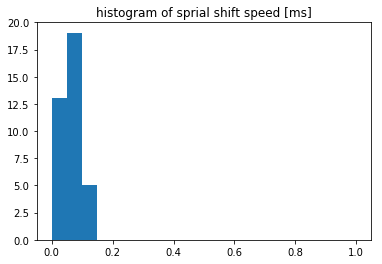

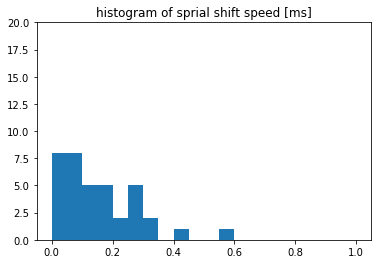

In [324]:
#print vel_pre.shape, vel_pst.shape
print len(vel_pre)
print len(vel_pst)
plt.hist(vel_pre, np.arange(0,1.01,0.05))
plt.title("histogram of sprial shift speed [ms]")
plt.ylim([0,20])
plt.show()
plt.hist(vel_pst, np.arange(0,1.01,0.05))
plt.title("histogram of sprial shift speed [ms]")
plt.ylim([0,20])
plt.show()

In [9]:
shift_thre = 10
step_t1 = 8
step_t2 = 8
step_l = 8

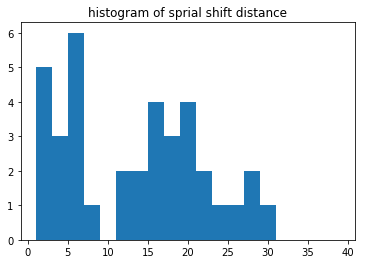

13.4597958066


In [10]:
plt.hist(stim_params[:,3], np.arange(1,40,2))
plt.title("histogram of sprial shift distance")
plt.show()
print np.mean(stim_params[:,3])

In [11]:
data_num = np.zeros((step_t1, step_t2, step_l))
data_suc = np.zeros((step_t1, step_t2, step_l))

success =(stim_params[:,3] > shift_thre) * 1.0
phi = ( ( stim_params[:,0]+np.pi) / ( np.pi / (step_t1/2) ) ).astype(np.int8)
theta = (stim_params[:,1] / ( np.pi / (2*step_t2) ) ).astype(np.int8)
l = (stim_params[:,2] / ((np.max(stim_params[:,2])+1)/step_l)).astype(np.int8)

for n , s in enumerate(success):
    i = phi[n]
    j = theta[n]
    k = l[n]
    
    data_num[i, j, k] += 1
    if s > 0: data_suc[i, j, k] += 1

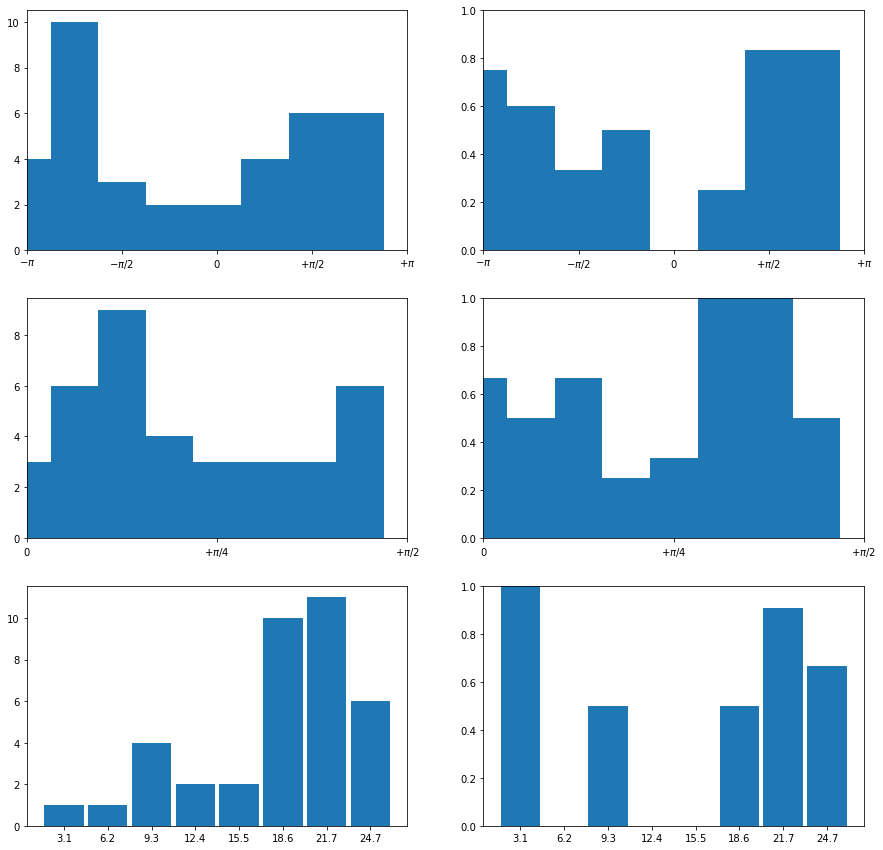

In [12]:
plt.figure(figsize=(15,15))

##--------------------##
## phi                     ##
##--------------------##

num = np.sum(data_num, axis=(1,2))
suc = np.sum(data_suc, axis=(1,2))
plt.subplot(3,2,1)
plt.bar(np.arange(-np.pi, np.pi, 2.*np.pi/step_t1), num, width=2.*np.pi/step_t1)
plt.xlim([-np.pi, np.pi])
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
          [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$+\pi/2$', r'$+\pi$'])
#plt.xlabel(r"$\theta_{1}$ [rad]")
plt.subplot(3,2,2)
plt.bar(np.arange(-np.pi, np.pi, 2.*np.pi/step_t1), (suc/(num+((num==0)*1))), width=2.*np.pi/step_t1)
plt.xlim([-np.pi, np.pi])
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
          [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$+\pi/2$', r'$+\pi$'])
plt.ylim([0,1])
#plt.xlabel(r"$\theta_{1}$ [rad]")

##-----------------------##
## theta                     ##
##-----------------------##

num = np.sum(data_num, axis=(0,2))
suc = np.sum(data_suc, axis=(0,2))
plt.subplot(3,2,3)
plt.bar(np.arange(0, .5*np.pi, .5*np.pi/step_t2), num, width=.5*np.pi/step_t2)
plt.xlim([0, .5*np.pi])
plt.xticks([0, np.pi/4, np.pi/2],
          [r'$0$', r'$+\pi/4$', r'$+\pi/2$'])
#plt.xlabel(r"$\theta_{2}$ [rad]")
plt.subplot(3,2,4)
plt.bar(np.arange(0, .5*np.pi, .5*np.pi/step_t2), (suc/(num+((num==0)*1))), width=.5*np.pi/step_t2)
plt.xlim([0, .5*np.pi])
plt.xticks([0, np.pi/4, np.pi/2], [r'$0$', r'$+\pi/4$', r'$+\pi/2$'])
#plt.xlabel(r"$\theta_{2}$ [rad]")
plt.ylim([0,1])


##-----------------##
## l                     ##
##-----------------##

num = np.sum(data_num, axis=(0,1))
suc = np.sum(data_suc, axis=(0,1))
ticks = [r'{0:.1f}'.format(v) for v in (np.arange(8)+1)*((np.max(stim_params[:,2])+1)/step_l) ]
plt.subplot(3,2,5)
plt.bar(np.arange(step_l), num, width=0.9, align='center')
plt.xticks(np.arange(8), ticks)
plt.subplot(3,2,6)
plt.bar(np.arange(step_l), (suc/(num+((num==0)*1))), width=0.9, align='center')
plt.ylim([0,1])
plt.xticks(np.arange(8), ticks)
plt.show()


## 解析